In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'IWF'
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_iwf.pkl' # Russell 1000
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


Generating derived columns...
(4165, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2008-01-02,60.970001,61.080002,59.810001,60.119999,49.339451,3.898724,0.986059,0.999501,1.002162
2008-01-03,60.250000,60.439999,59.849998,60.090000,49.314850,3.898225,0.997344,0.969212,0.991513
2008-01-04,59.580002,59.580002,58.240002,58.240002,47.796562,3.866954,0.977509,1.003091,1.006353
2008-01-07,58.610001,58.740002,57.790001,58.419998,47.944294,3.870040,0.996758,0.984594,1.000685
2008-01-08,58.459999,59.000000,56.700001,57.520000,47.205685,3.854514,0.983921,1.012865,1.000695
2008-01-09,57.560001,58.459999,56.930000,58.259998,47.812988,3.867297,1.012161,1.004120,0.995022
2008-01-10,57.970001,58.930000,57.689999,58.500000,48.009956,3.871408,1.009143,0.986496,0.994701
2008-01-11,58.189999,58.279999,57.400002,57.709999,47.361622,3.857812,0.991751,1.012476,1.005198
2008-01-14,58.009998,58.439999,57.919998,58.430000,47.952507,3.870211,1.007240,0.979120,0.986137


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2008-01-02     61.080002
2008-01-03     60.439999
2008-01-04     59.580002
2008-01-07     58.740002
2008-01-08     59.000000
                 ...    
2024-07-15    381.299988
2024-07-16    379.760010
2024-07-17    371.000000
2024-07-18    369.700012
2024-07-19    366.149994
Name: high, Length: 4164, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2009-01-02')  # first day of legit open/close values
SIM_START

Timestamp('2009-01-02 00:00:00')

In [7]:
len(df.index >= SIM_START)

4165

In [8]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [9]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [10]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

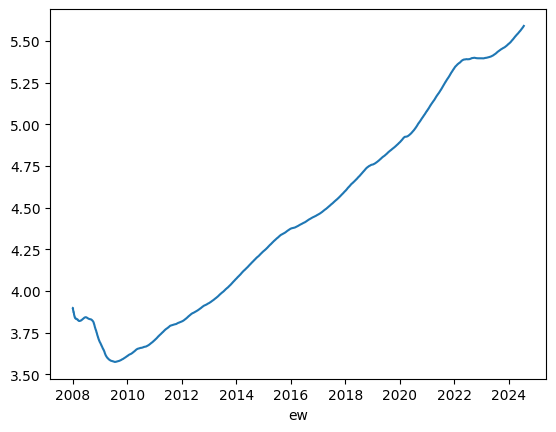

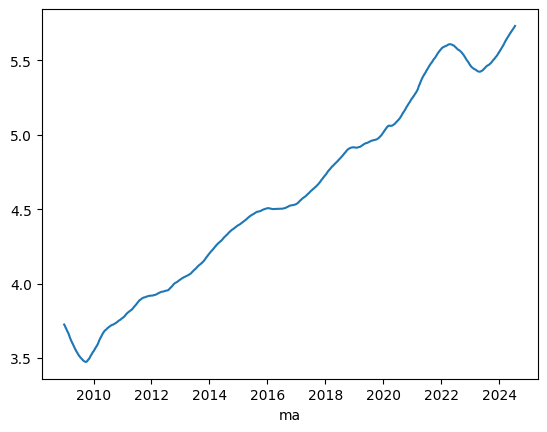

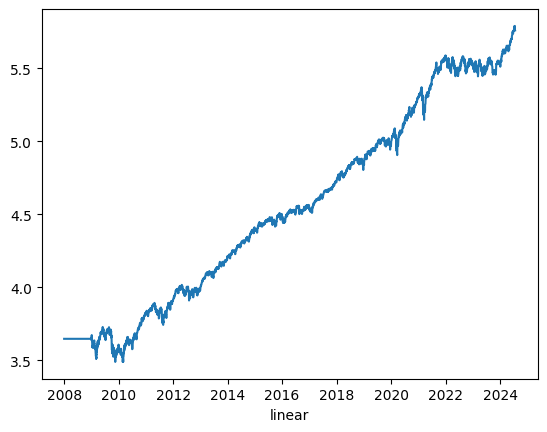

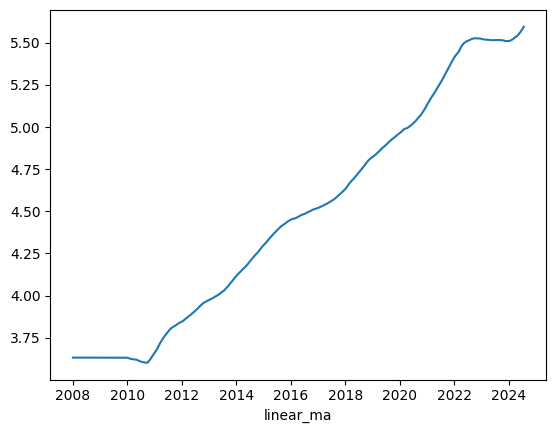

In [11]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [12]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [13]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [14]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [15]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [16]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [17]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(39.99265121782698,
 {'time_param': 133,
  'method': 'ew',
  't': 0.9693992431393703,
  'k': 8.072993125894225,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})

Do nothing res: 11.38952650962195
Round 1: 39.714424599573384
New best: 39.714424599573384
{'time_param': 133, 'method': 'ew', 't': 0.9693992431393703, 'k': 8.072993125894225, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


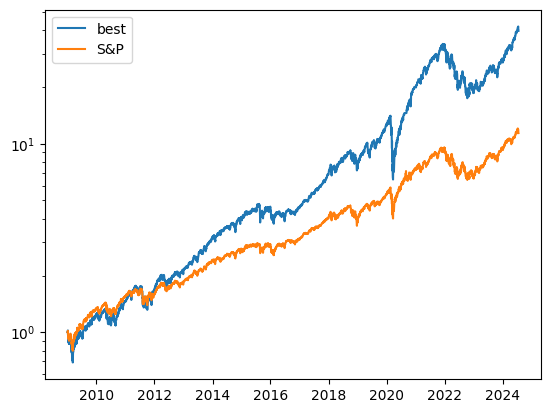

Round 2: 1.7808511787748584
Round 3: 5.146081636701037
Round 4: 3.431349815463904
Round 5: 36.29218088914809
Round 6: 3.5078790744111883
Round 7: 23.04490335256469
Round 8: 1.5553115334880263
Round 9: 6.3497474640634
Round 10: 1.387048169072679
Round 11: 28.023880465563057
Round 12: 34.71055847132509
Round 13: 2.436940173454635
Round 14: 8.879959304414221
Round 15: 10.248235584119156
Round 16: 4.236154362502008
Round 17: 1.7709108937460922
Round 18: 37.94997061998643
Round 19: 1.3176597436014579
Round 20: 2.391030101862284
Round 21: 1.1172929477306826
Round 22: 1.0957838860595286
Round 23: 4.9980416836893715
Round 24: 1.0149597536195805
Round 25: 15.278719204896493
Round 26: 34.28932216011533
Round 27: 1.050470936934524
Round 28: 1.1583659291132082
Round 29: 6.21990033349663
Round 30: 15.289731953204164
Round 31: 32.91082485371662
Round 32: 3.621700229989467
Round 33: 25.649095005185146
Round 34: 5.088826966751474
Round 35: 1.994059181782922
Round 36: 12.538158267898968
Round 37: 6.776

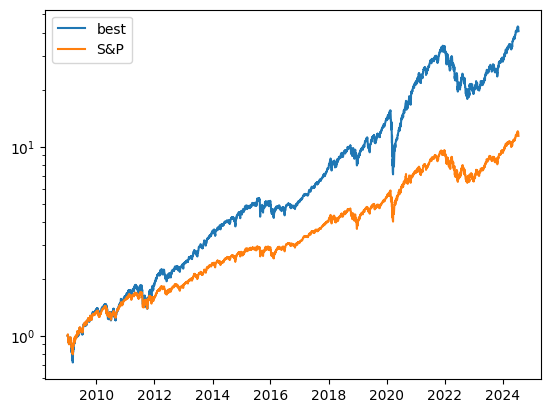

Round 93: 10.68222826288011
Round 94: 8.586226791142272
Round 95: 9.533039662005763
Round 96: 3.4758467419766026
Round 97: 1.100540712304741
Round 98: 34.74073865112385
Round 99: 3.60117465102904
Round 100: 4.952340302755172


In [18]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 11.38952650962195
Round 1: 37.02433778759974
Round 2: 40.57968168950552
Round 3: 39.64162061671373
Round 4: 35.258498747277216
Round 5: 34.11714300943243
Round 6: 39.512804609376985
Round 7: 36.230993240939036
Round 8: 34.185120379242115
Round 9: 34.98743471483155
Round 10: 34.624001911666866
Round 11: 40.09827564896224
Round 12: 34.02665640667485
Round 13: 3.0475989023511927
Round 14: 13.757682701498124
Round 15: 40.71145308802415
Round 16: 40.53475096637759
Round 17: 40.203515789033226
Round 18: 34.61390398218861
Round 19: 39.622585263220586
Round 20: 38.979345840511044
Round 21: 39.67936543649431
Round 22: 26.25819482131454
Round 23: 39.77585696430463
Round 24: 5.439844146044363
Round 25: 39.64934917533033

Factor: 1.03125
Do nothing res: 11.38952650962195
Round 1: 39.359145017290544
Round 2: 39.63454998380182
Round 3: 36.67174606421918
Round 4: 34.114539985493195
Round 5: 34.622430107111086
Round 6: 34.62098558404638
Round 7: 34.11107172048141
Round 8

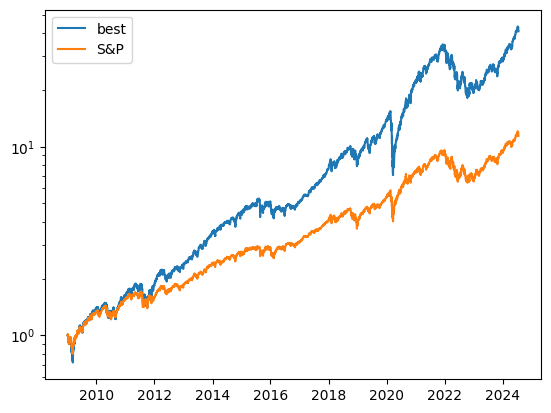

Round 6: 39.79971167544099
Round 7: 34.61412960607896
Round 8: 34.61362841003465
Round 9: 37.90110084980628
Round 10: 38.57165066609917
Round 11: 40.536587131269556
Round 12: 28.12878439282116
Round 13: 34.616547191821255
Round 14: 40.73752046651587
Round 15: 37.17760847911005
Round 16: 40.35318757050119
Round 17: 39.69767263777681
Round 18: 40.81940966416607
New best: 40.81940966416607
{'time_param': 34, 'method': 'ma', 't': 0.8854577309043978, 'k': 9.093007845943394, 'as_q': True, 'transform_f': 'bounded_curve'}


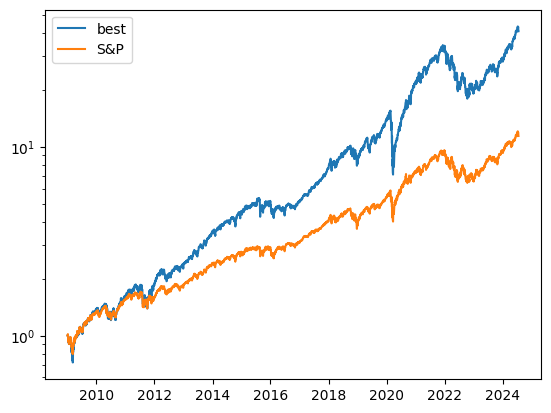

Round 19: 36.27941656298421
Round 20: 34.6150627702397
Round 21: 40.48955893468408
Round 22: 34.61330895090001
Round 23: 34.61412999036782
Round 24: 34.61398318333947
Round 25: 39.98212141185047

Factor: 1.0078125
Do nothing res: 11.38952650962195
Round 1: 40.076669498787076
Round 2: 34.614773964706785
Round 3: 34.61528516782834
Round 4: 34.61410381869355
Round 5: 34.61733454571366
Round 6: 41.09663301358096
New best: 41.09663301358096
{'time_param': 33, 'method': 'ma', 't': 0.9089118424936447, 'k': 9.094148675973667, 'as_q': True, 'transform_f': 'bounded_curve'}


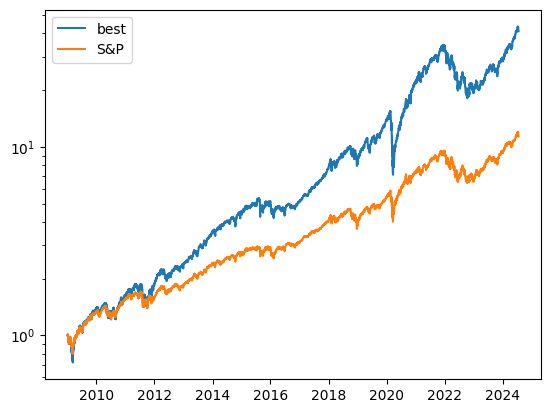

Round 7: 40.77857912029491
Round 8: 40.96361156523334
Round 9: 27.502406762319747
Round 10: 34.6254752775008
Round 11: 19.970341657458505
Round 12: 35.211756771885106
Round 13: 29.442894193595617
Round 14: 40.95522427552073
Round 15: 34.62356349168845
Round 16: 38.69132974600436
Round 17: 34.623482931339076
Round 18: 40.56802712017588
Round 19: 37.559473361215055
Round 20: 26.669298776567388
Round 21: 33.261614252817026
Round 22: 34.62272827238286
Round 23: 34.621836187594106
Round 24: 34.62512354071465
Round 25: 38.86521798248502



In [19]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [20]:
# Force set:
#best_out = 8.746647001172413
#params_out = {'time_param': 39, 'method': 'ma', 't': 0.9119734669470952, 'k': 6.934678320149607, 'as_q': True, 'transform_f': 'bounded_curve'}

In [21]:
final_out = simulate(df, params_out)

In [22]:
amt_in = final_out['amt_in'][-1]
amt_in

1.0

In [23]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.24878993223620524

In [24]:
params_out

{'time_param': 33,
 'method': 'ma',
 't': 0.9089118424936447,
 'k': 9.094148675973667,
 'as_q': True,
 'transform_f': 'bounded_curve'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:24: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + x**(np.log(2) / np.log(t)) - 1) ** k


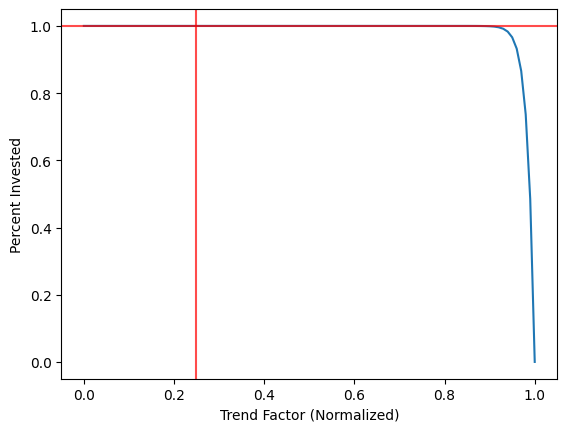

In [25]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

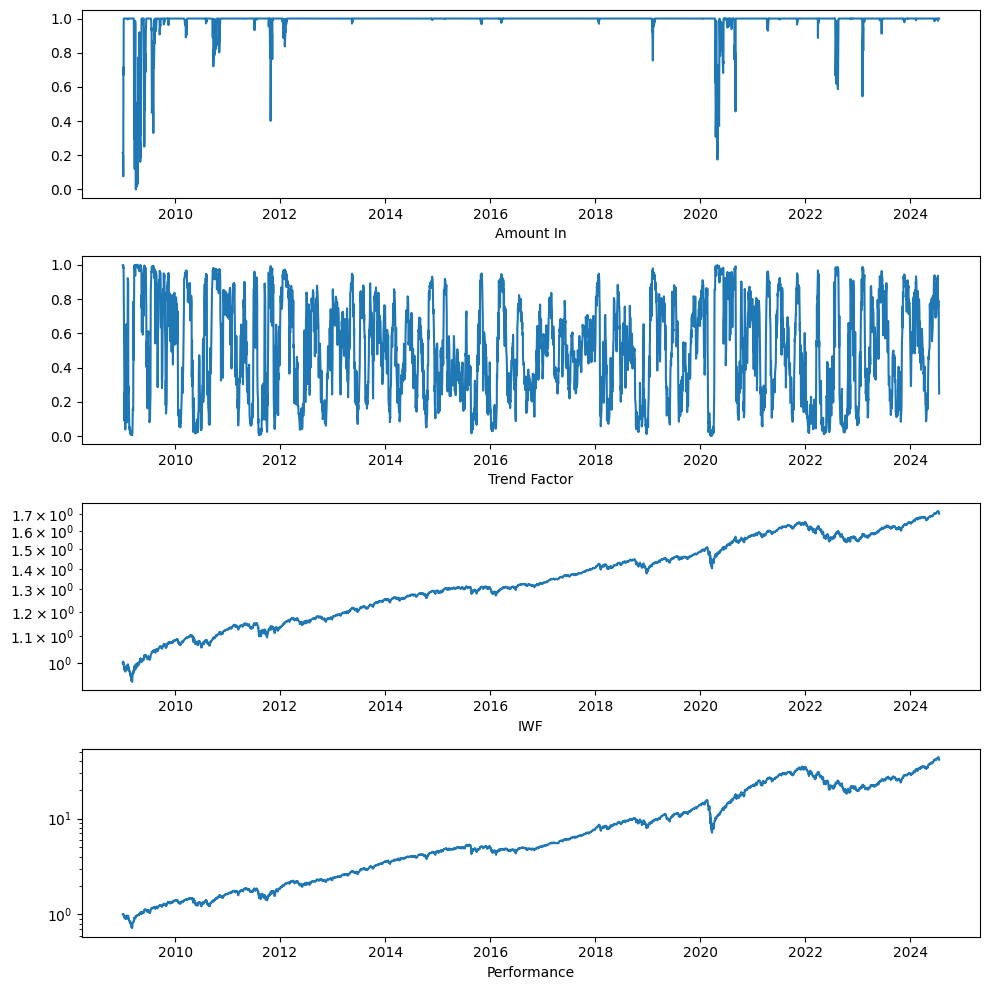

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('IWF')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [27]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Wilshire')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

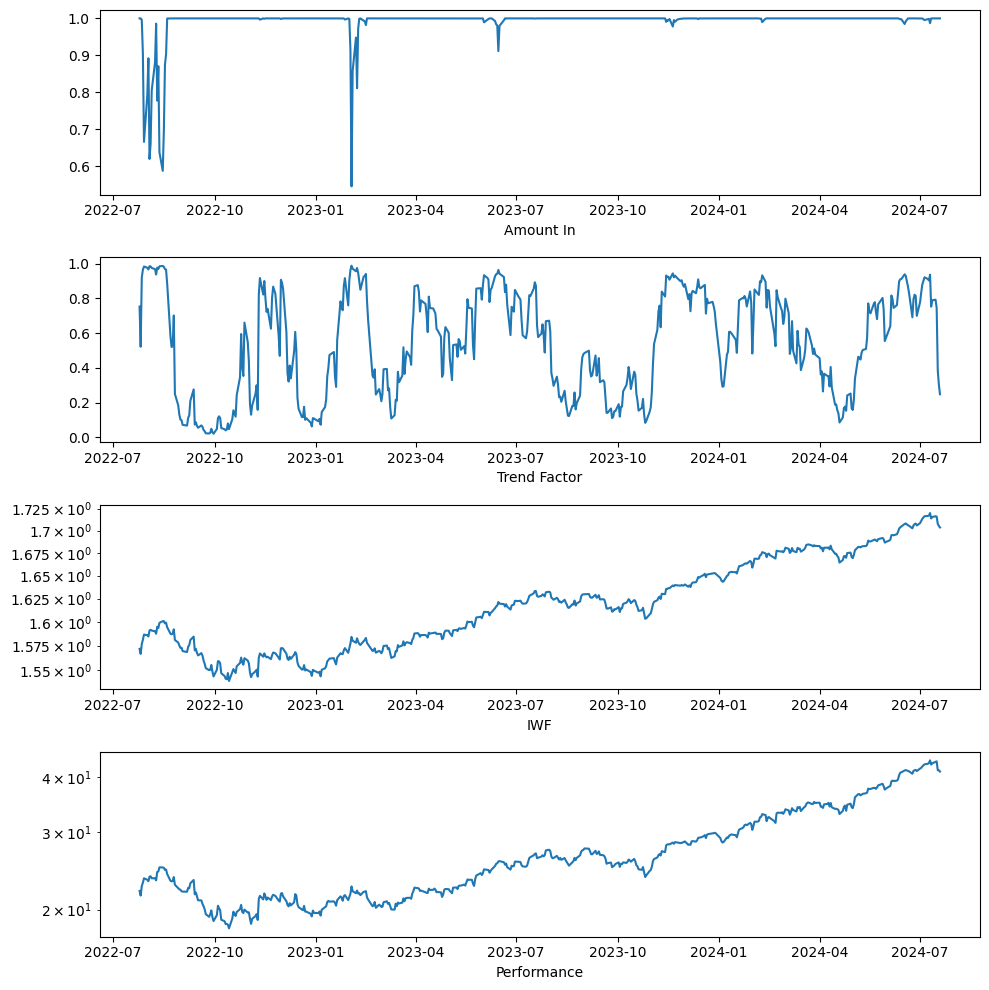

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('IWF')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [29]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

1.0

In [30]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(31.75636863708496, 15.648, 361.69000244140625)

In [31]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.26803660150160336

In [32]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['rus'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.1174873659325364, 0.9999], 'nas': [1.2275959942624421, 0.9982], 'rus': [1.2680366015016034, 1.0], 'jpxn': [1.0672456187347374, 0.0], 'ktec': [1.6599402811386, 0.0], 'emb': [1.0686835821410459, 1.0], 'gdx': [1.3355529773650587, 0.2463], 'dia': [1.2015064238720055, 1.0]}


In [33]:
stop

NameError: name 'stop' is not defined

In [34]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(41.09663301358096,
 {'time_param': 33,
  'method': 'ma',
  't': 0.9089118424936447,
  'k': 9.094148675973667,
  'as_q': True,
  'transform_f': 'bounded_curve'})